In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from data import wirtual
import random

In [28]:
wirtual_flat = [item for sublist in wirtual for item in sublist]
print(len(wirtual))

def rolling_avg(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        if i < window_size - 1:
            # For the first few elements, average the elements from the start to the current position
            rolling_avg[i] = np.mean(sequence[:i+1])
        else:
            # For the rest, compute the average of the window
            rolling_avg[i] = np.mean(sequence[i-window_size+1:i+1])
    return rolling_avg

def rolling_avg_both_sides(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        start = i-window_size//2+1
        end = start+window_size
        if start<0:
            start=0
        if end > len(sequence):
            end=len(sequence)
        rolling_avg[i] = np.mean(sequence[start:end])
    return rolling_avg

def rolling_avg_both_sides_asym(sequence, left, right):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        start = i-left
        end = i+right+1
        if start<0:
            start=0
        if end > len(sequence):
            end=len(sequence)
        rolling_avg[i] = np.mean(sequence[start:end])
    return rolling_avg

def remove_repeated_elements(arr):
    if not arr:
        return []
    result = [arr[0]]
    for el in arr:
        if el != result[-1]:
            result.append(el)
    return result

def exp_smoothing_average(sequence, alpha=0.05):
    avg = np.zeros_like(sequence, dtype=float)
    for i in range(1, len(sequence)):
        avg[i] = alpha*sequence[i] + (1-alpha)*(avg[i-1])
    return avg

def logistic_curve(n, low, high, shift, speed):
    return low + (high-low) / (1 + np.exp(-speed * (n-shift)))

def loss_logistic(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    loss = np.mean((sequence - predicted_probs)**2)
    return np.sum(loss)

def neg_log_likelihood(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    predicted_probs = np.clip(predicted_probs, 0.00000001, 0.99999999)
    loss = np.sum(-(sequence * np.log(predicted_probs) + (1-sequence) * np.log(1-predicted_probs)))
    return loss    

class Floor:
    
    def __init__(self):
        self.floor = None
        self.successes = None
        self.params = None
        self.rolling_avg = None
        self.fail_distribution = None
            
    @classmethod
    def from_data(cls, data, floor):
        obj = Floor()
        obj.floor = floor
        
        # Calculate successes and fail distribution
        obj.successes = []
        obj.fail_distribution = {i: 0 for i in range(floor+1)}
        for i in range(len(data)-1):
            if data[i] == floor:
                if data[i+1] == floor+1:
                    obj.successes.append(1)
                else:
                    obj.successes.append(0)
                    obj.fail_distribution[data[i+1]] += 1
        obj.successes = np.array(obj.successes)
                    
        # Compute rolling average
        window_size = 20
        obj.rolling_avg = rolling_avg(obj.successes, window_size)
        #obj.prob = rolling_avg_both_sides_asym(obj.successes, 40, 10)
        #obj.prob = exp_smoothing_average(obj.successes)
        
        # Train model
        initial_params = [0.0, 0.7, 0.9, 0.9]
        bounds = [(-10, 1), (0, 1), (-100, 300), (0, 30)]
        result = minimize(neg_log_likelihood, initial_params, args=(obj.successes,), bounds=bounds, method='L-BFGS-B')
        #result = minimize(loss_logistic, initial_params, args=(obj.prob,), method='L-BFGS-B')
        if result.success:
            obj.params = result.x
        else:
            print("Optimization failed:", result.message)
        return obj
            
    @classmethod
    def from_params(cls, floor, low, high, shift, speed):
        obj = Floor()
        obj.floor = floor
        obj.successes = list(range(100))
        obj.params = (low, high, shift, speed)
        obj.fail_distribution = {i:1 for i in range(floor)}
        return obj
            
    def simulate_one_step(self, attempt):
        p = logistic_curve(attempt, *self.params)
        if random.random() <= p:
            return self.floor + 1
        else:
            keys = list(self.fail_distribution.keys())
            weights = list(self.fail_distribution.values())
            sample = random.choices(keys, weights=weights, k=1)[0]
            return sample
            
    def plot(self):
        # Generate x values
        if self.rolling_avg is not None:
            x_values = np.arange(len(self.rolling_avg))
        else:
            x_values = np.arange(200)

        low, high, shift, speed = self.params

        # Calculate y values
        y_values = logistic_curve(x_values, low, high, shift, speed)

        # Plotting the result
        plt.figure(figsize=(10, 3))
        plt.plot(x_values, y_values, label='Logistic Curve')
        if self.rolling_avg is not None:
            plt.plot(x_values, self.rolling_avg, label="Rolling Average")
        plt.title(f'Floor {self.floor}')
        plt.xlabel('Attempts')
        plt.ylabel('Success Probability')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.show()

99


In [30]:
#wirtual_flat = remove_repeated_elements(wirtual_flat)
wirtual_first_time_reached_floor = []
for i in range(18):
    try:
        wirtual_first_time_reached_floor.append(wirtual_flat.index(i))
    except:
        pass
wirtual_first_time_reached_floor

[0, 3, 26, 218, 283, 612, 662, 1196, 1885, 2249, 2513, 2820]

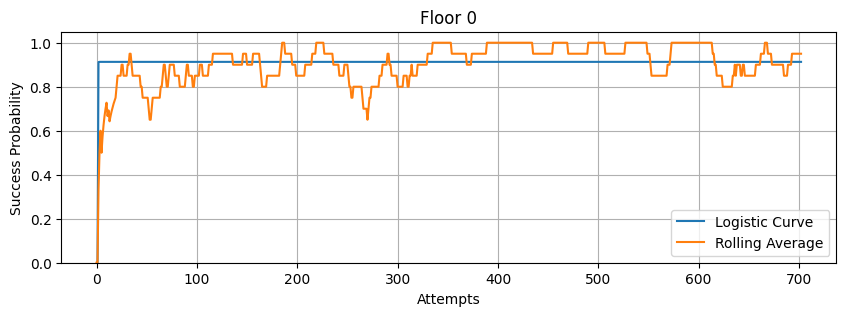

low=-0.01, high=0.91, shift=1.60, speed=17.78


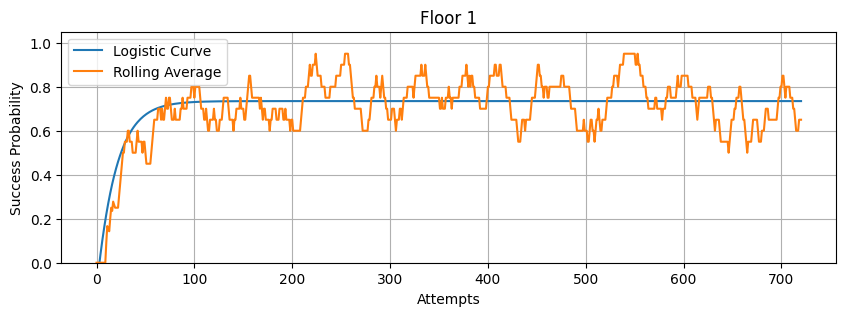

low=-10.00, high=0.73, shift=-45.43, speed=0.05


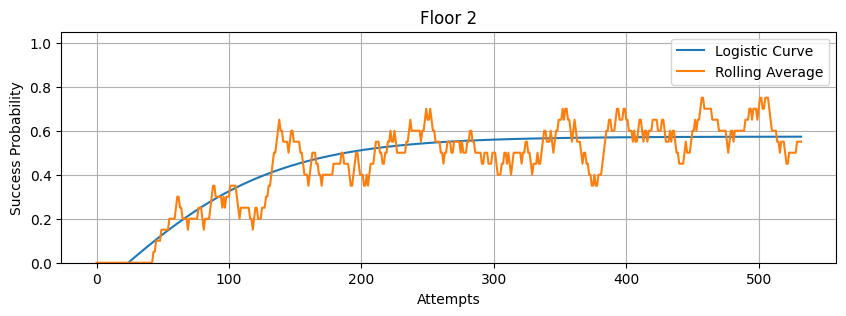

low=-0.81, high=0.57, shift=1.26, speed=0.02


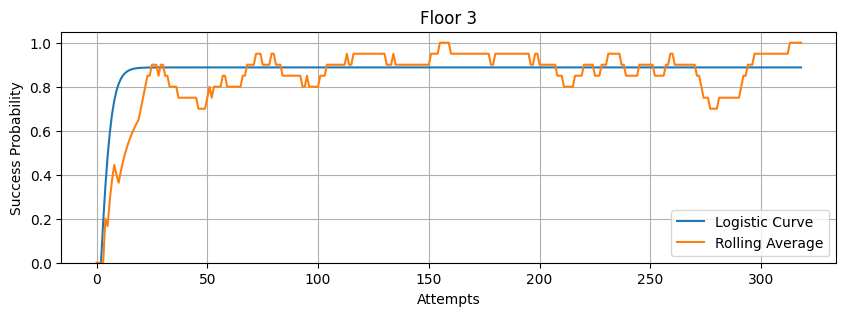

low=-1.18, high=0.89, shift=1.25, speed=0.38


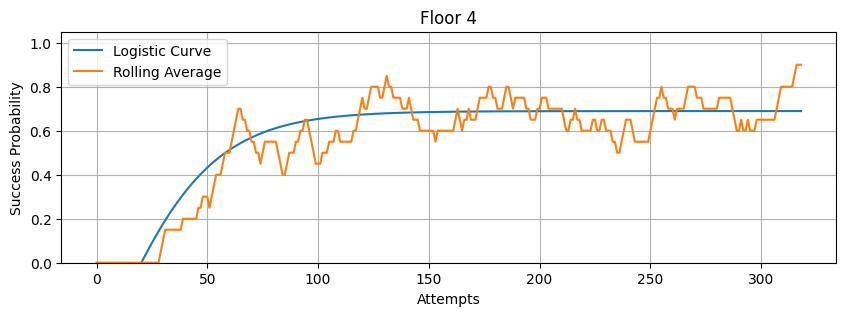

low=-1.50, high=0.69, shift=1.49, speed=0.04


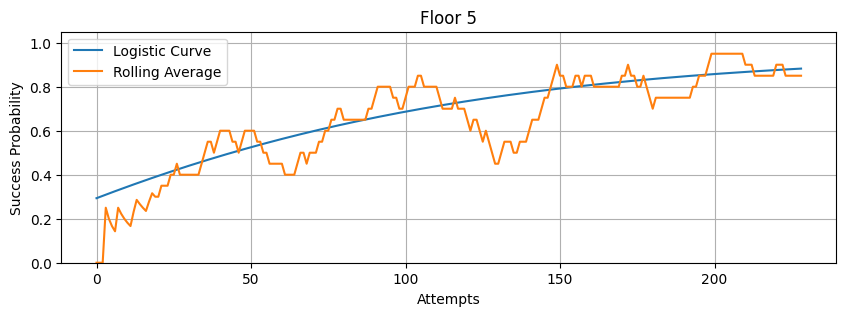

low=-1.67, high=0.95, shift=-100.00, speed=0.01


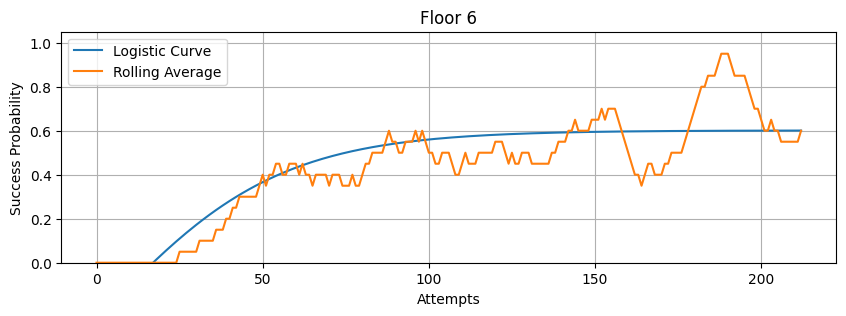

low=-1.08, high=0.60, shift=1.34, speed=0.04


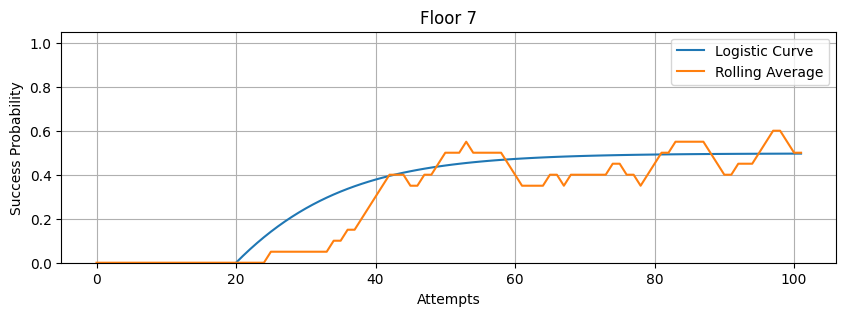

low=-2.13, high=0.50, shift=1.69, speed=0.08


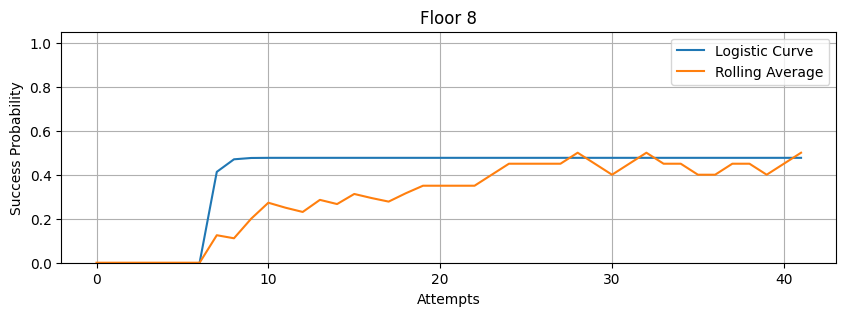

low=-1.32, high=0.48, shift=5.55, speed=2.28


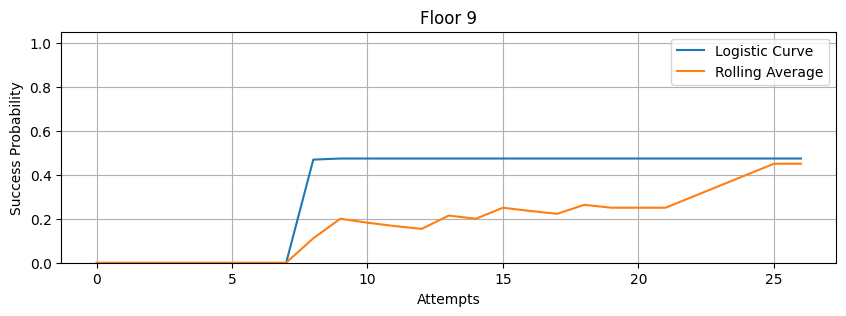

low=-1.57, high=0.47, shift=6.75, speed=4.82


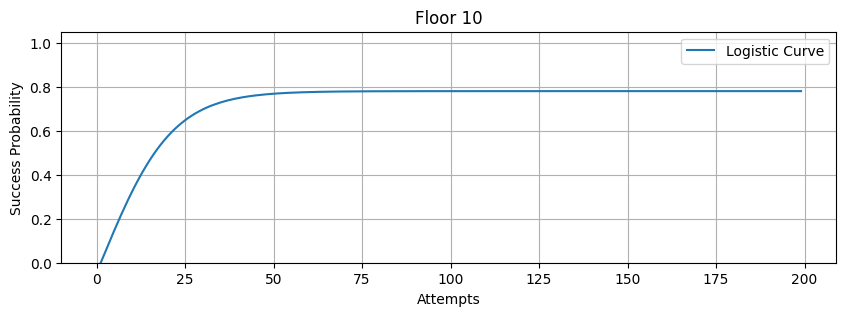

low=-0.77, high=0.78, shift=1.32, speed=0.10


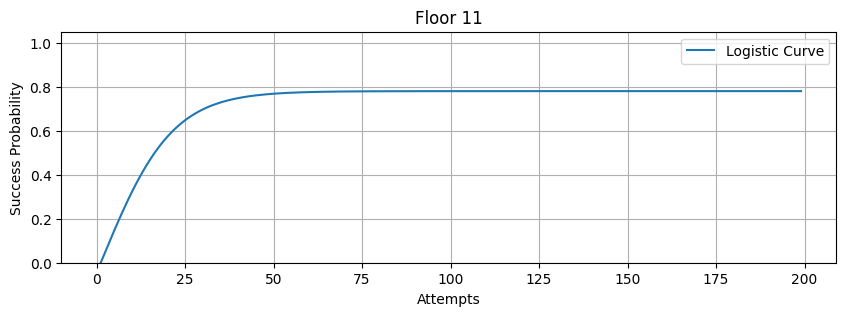

low=-0.77, high=0.78, shift=1.32, speed=0.10


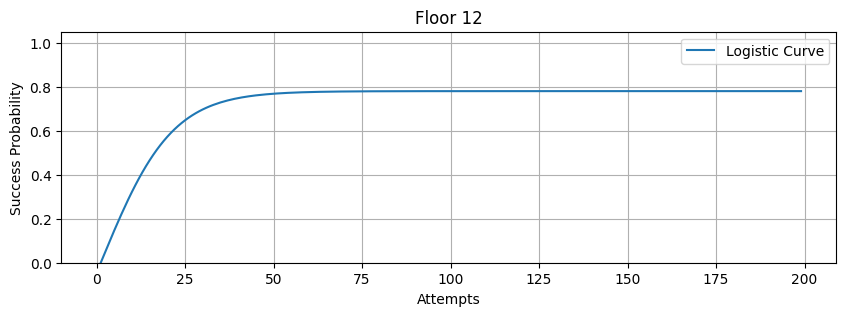

low=-0.77, high=0.78, shift=1.32, speed=0.10


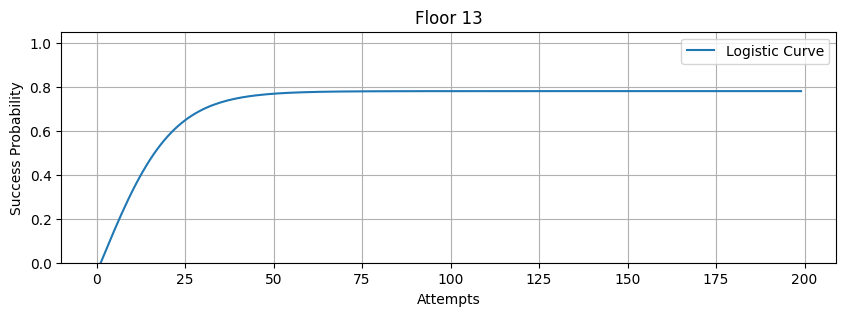

low=-0.77, high=0.78, shift=1.32, speed=0.10


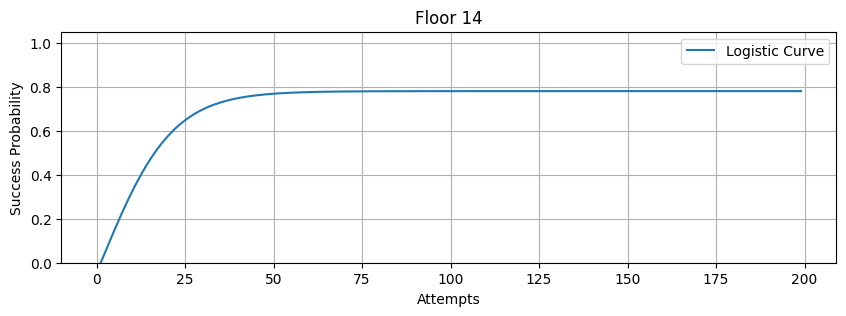

low=-0.77, high=0.78, shift=1.32, speed=0.10


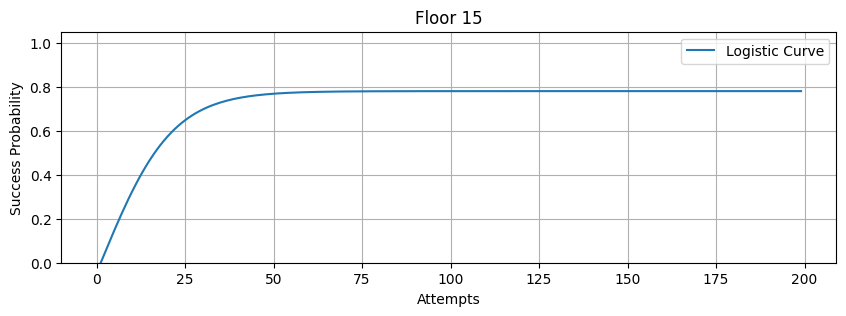

low=-0.77, high=0.78, shift=1.32, speed=0.10


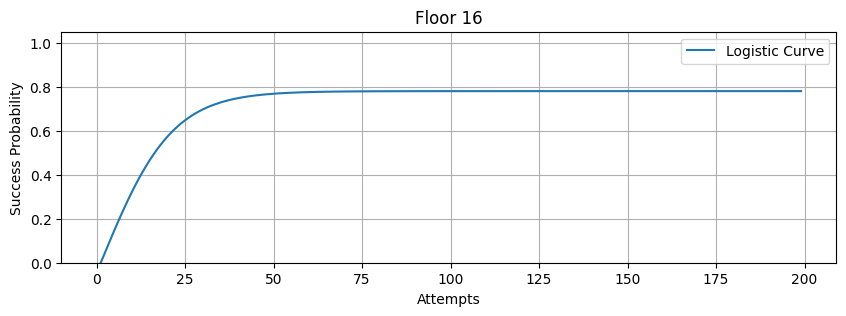

low=-0.77, high=0.78, shift=1.32, speed=0.10


In [31]:
floors = []
for i in range(10):
    floors.append(Floor.from_data(wirtual_flat, i))
    
for i in range(10, 17):
    floors.append(Floor.from_params(i, -0.77, 0.78, 1.32, 0.1))
    
for floor in floors:
    floor.plot()
    print(f"low={floor.params[0]:.2f}, high={floor.params[1]:.2f}, shift={floor.params[2]:.2f}, speed={floor.params[3]:.2f}")

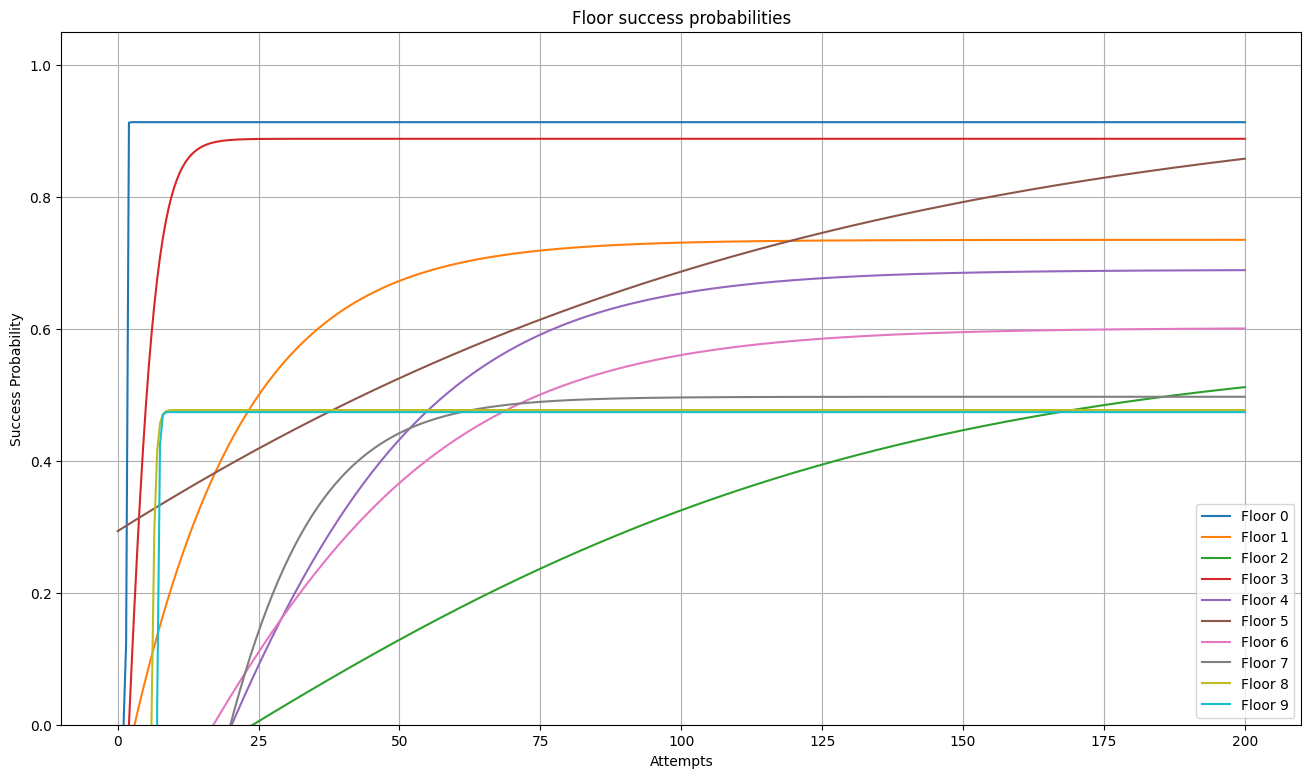

In [33]:
# Plot all floor probabilities in one plot
x_values = np.linspace(0, 200, 400)
plt.figure(figsize=(16, 9))
plt.title(f'Floor success probabilities')
plt.xlabel('Attempts')
plt.ylabel('Success Probability')
plt.ylim(0, 1.05)
plt.grid(True)
for floor in floors[:10]:
    # Calculate y values
    low, high, shift, speed = floor.params
    y_values = logistic_curve(x_values, low, high, shift, speed)
    plt.plot(x_values, y_values, label=f'Floor {floor.floor}')
plt.legend()
plt.show()

In [23]:
prod = 1.0
for i in range(17):
    prod *= floors[i].params[1]
    print(f"Assuming enough practice, the chance to go through to floor {i+1} without fall: {prod}")

Assuming enough practice, the chance to go through to floor 1 without fall: 1.0
Assuming enough practice, the chance to go through to floor 2 without fall: 0.7329033846592763
Assuming enough practice, the chance to go through to floor 3 without fall: 0.4201374457844368
Assuming enough practice, the chance to go through to floor 4 without fall: 0.3729857837031744
Assuming enough practice, the chance to go through to floor 5 without fall: 0.2570910038840887
Assuming enough practice, the chance to go through to floor 6 without fall: 0.24312931575725086
Assuming enough practice, the chance to go through to floor 7 without fall: 0.15015167003319135
Assuming enough practice, the chance to go through to floor 8 without fall: 0.07191418924788207
Assuming enough practice, the chance to go through to floor 9 without fall: 0.0349052727154624
Assuming enough practice, the chance to go through to floor 10 without fall: 0.01619109105814887
Assuming enough practice, the chance to go through to floor 

In [24]:
results = []
for sim in range(1000):
    attempts = {i:0 for i in range(17)}
    first_time_reached_floor = [0]
    highest_reached_floor = 0
    current_floor = 0
    counter = 0
    while current_floor < 17:
        attempt_number = attempts[current_floor]
        new_floor = floors[current_floor].simulate_one_step(attempt_number)
        attempts[current_floor] += 1
        current_floor = new_floor
        counter += 1
        if current_floor > highest_reached_floor:
            highest_reached_floor = current_floor
            first_time_reached_floor.append(counter)
    results.append(first_time_reached_floor)
    if sim % 100 == 0:
        print(f"Simulations done: {sim}")

Simulations done: 0
Simulations done: 100
Simulations done: 200
Simulations done: 300
Simulations done: 400
Simulations done: 500
Simulations done: 600
Simulations done: 700
Simulations done: 800
Simulations done: 900


Minimum number of steps: 1 (0 hours)
Mean number of steps: 1 (0 hours)
Maximum number of steps: 1 (0 hours)
Standard deviation: 0 (0 hours)
Actually first time reached: 0 hours


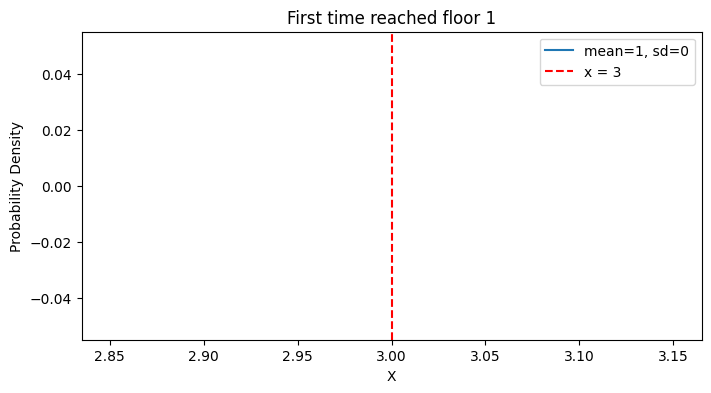

Minimum number of steps: 6 (0 hours)
Mean number of steps: 20 (1 hours)
Maximum number of steps: 45 (1 hours)
Standard deviation: 7 (0 hours)
Actually first time reached: 1 hours


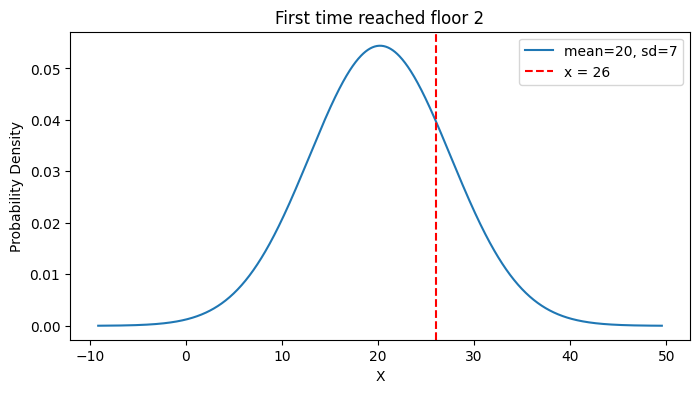

Minimum number of steps: 118 (4 hours)
Mean number of steps: 192 (6 hours)
Maximum number of steps: 347 (11 hours)
Standard deviation: 35 (1 hours)
Actually first time reached: 7 hours


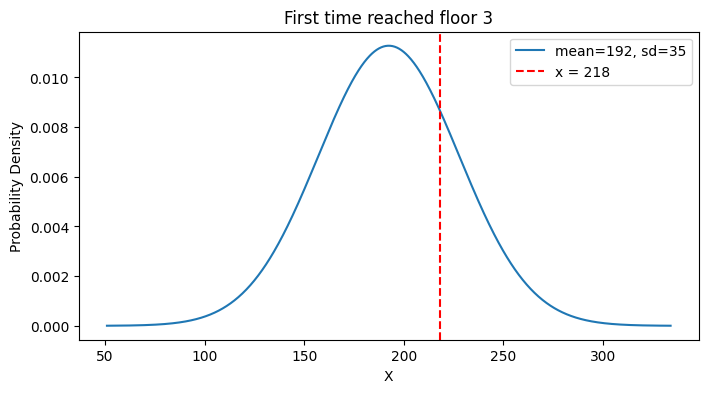

Minimum number of steps: 153 (5 hours)
Mean number of steps: 286 (9 hours)
Maximum number of steps: 429 (13 hours)
Standard deviation: 44 (1 hours)
Actually first time reached: 9 hours


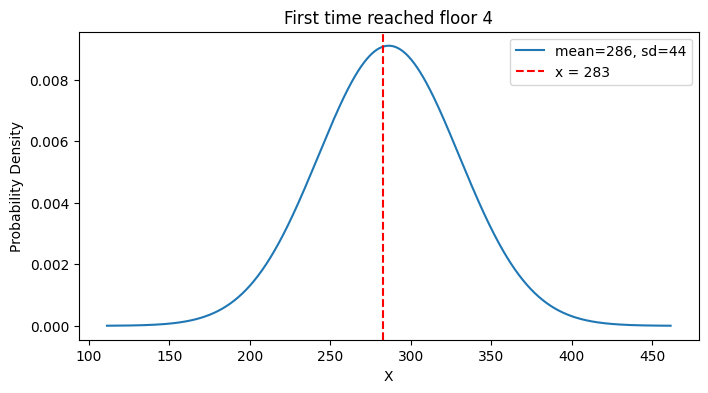

Minimum number of steps: 399 (12 hours)
Mean number of steps: 557 (17 hours)
Maximum number of steps: 793 (24 hours)
Standard deviation: 61 (2 hours)
Actually first time reached: 19 hours


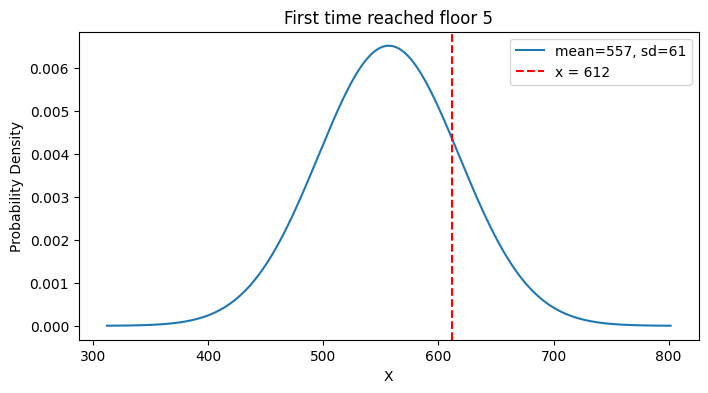

Minimum number of steps: 409 (13 hours)
Mean number of steps: 604 (19 hours)
Maximum number of steps: 952 (29 hours)
Standard deviation: 80 (2 hours)
Actually first time reached: 20 hours


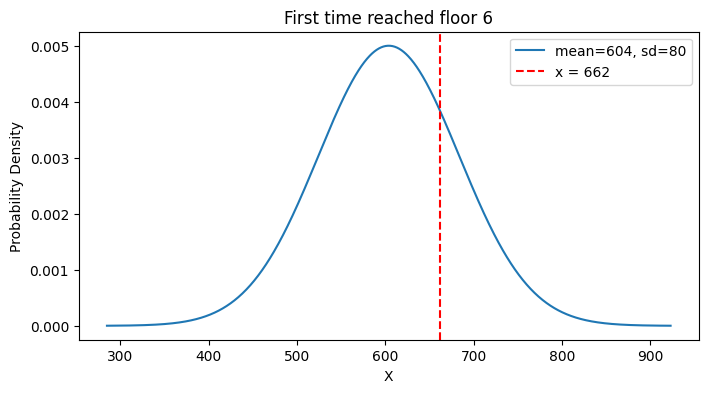

Minimum number of steps: 827 (25 hours)
Mean number of steps: 1170 (36 hours)
Maximum number of steps: 1709 (52 hours)
Standard deviation: 132 (4 hours)
Actually first time reached: 37 hours


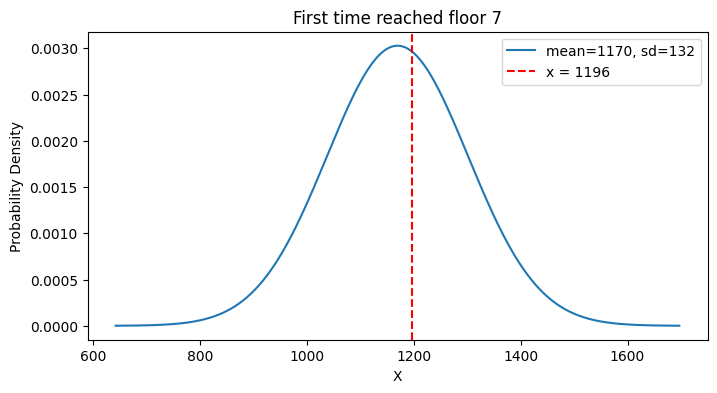

Minimum number of steps: 1435 (44 hours)
Mean number of steps: 1930 (59 hours)
Maximum number of steps: 2553 (78 hours)
Standard deviation: 158 (5 hours)
Actually first time reached: 58 hours


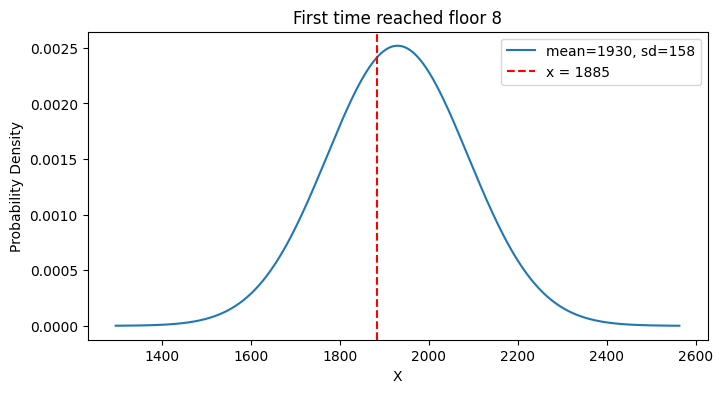

Minimum number of steps: 1776 (55 hours)
Mean number of steps: 2274 (70 hours)
Maximum number of steps: 3050 (94 hours)
Standard deviation: 183 (6 hours)
Actually first time reached: 69 hours


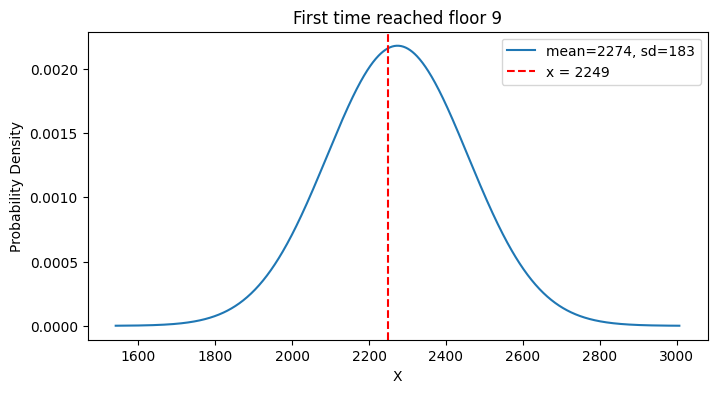

Minimum number of steps: 1966 (60 hours)
Mean number of steps: 2538 (78 hours)
Maximum number of steps: 3426 (105 hours)
Standard deviation: 234 (7 hours)
Actually first time reached: 77 hours


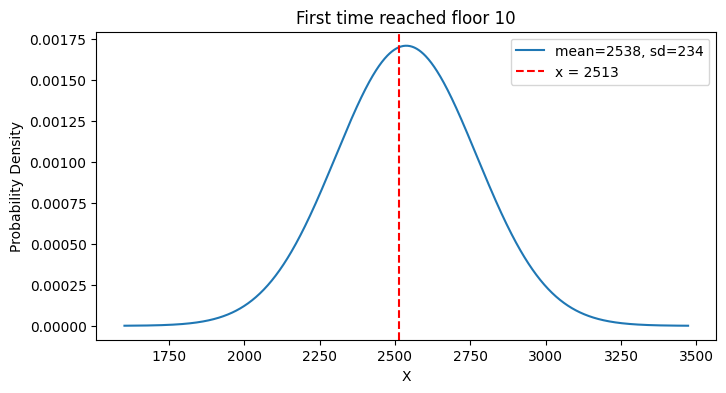

Minimum number of steps: 2168 (67 hours)
Mean number of steps: 3160 (97 hours)
Maximum number of steps: 4848 (149 hours)
Standard deviation: 434 (13 hours)
Actually first time reached: 87 hours


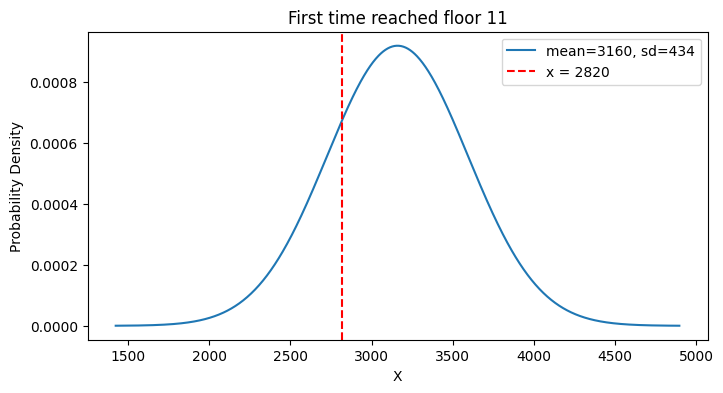

Minimum number of steps: 2698 (83 hours)
Mean number of steps: 4357 (134 hours)
Maximum number of steps: 6927 (213 hours)
Standard deviation: 670 (21 hours)


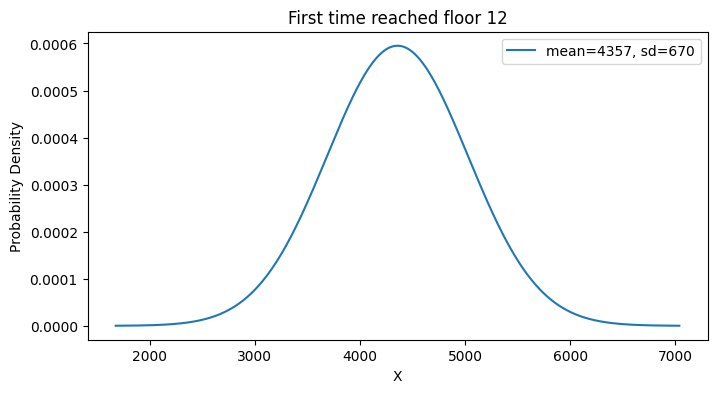

Minimum number of steps: 3973 (122 hours)
Mean number of steps: 5962 (183 hours)
Maximum number of steps: 9240 (284 hours)
Standard deviation: 917 (28 hours)


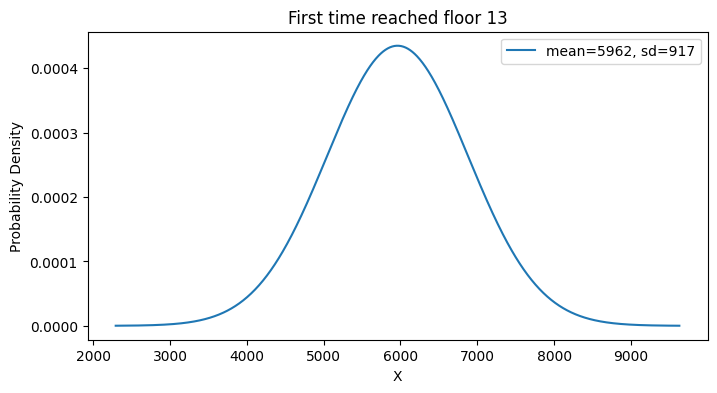

Minimum number of steps: 4970 (153 hours)
Mean number of steps: 7932 (243 hours)
Maximum number of steps: 12796 (393 hours)
Standard deviation: 1150 (35 hours)


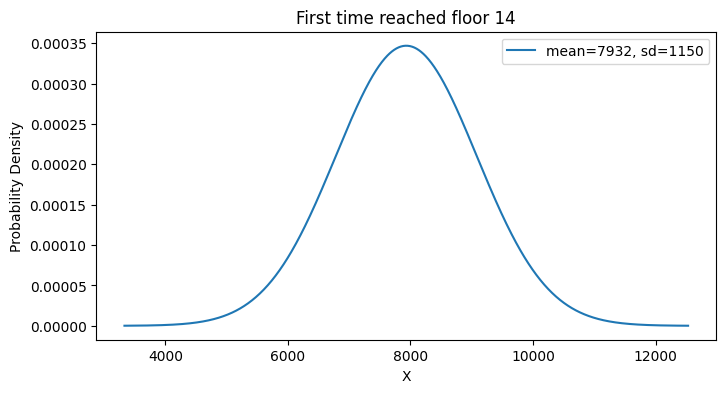

Minimum number of steps: 6625 (203 hours)
Mean number of steps: 10307 (316 hours)
Maximum number of steps: 16393 (503 hours)
Standard deviation: 1453 (45 hours)


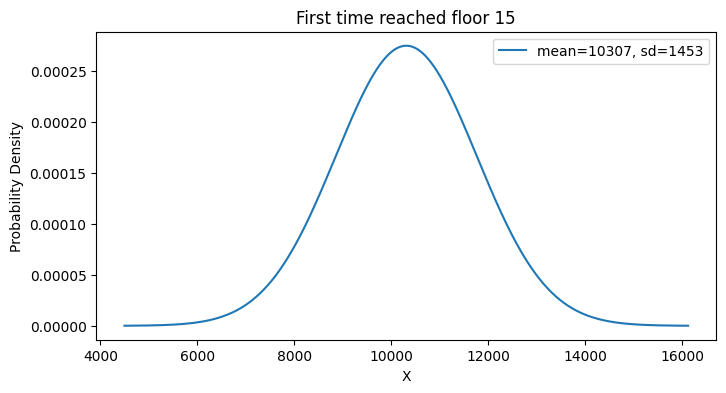

Minimum number of steps: 8373 (257 hours)
Mean number of steps: 13181 (405 hours)
Maximum number of steps: 19672 (604 hours)
Standard deviation: 1793 (55 hours)


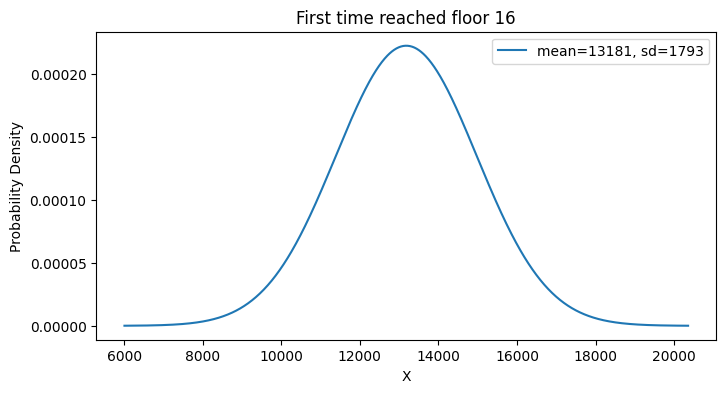

Minimum number of steps: 9938 (305 hours)
Mean number of steps: 16685 (512 hours)
Maximum number of steps: 25132 (771 hours)
Standard deviation: 2170 (67 hours)


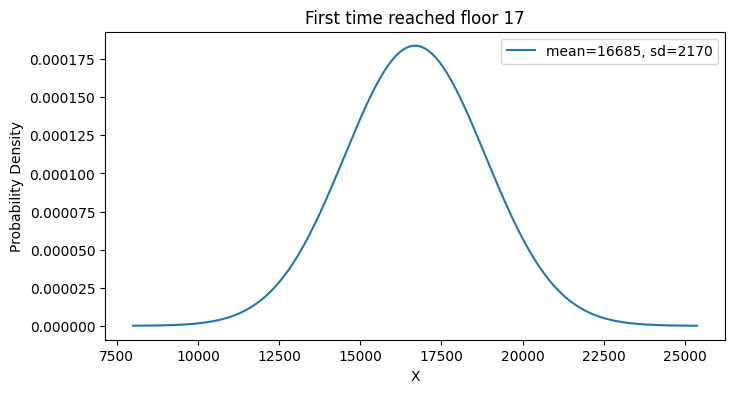

In [37]:
def gauss(mean, sd, title=None, highlight=None):
    x_values = np.linspace(mean - 4*sd, mean + 4*sd, 1000)
    y_values = norm.pdf(x_values, mean, sd)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, y_values, label=f'mean={mean:.0f}, sd={sd:.0f}')
    if highlight is not None:
        plt.axvline(x=highlight, color='r', linestyle='--', label=f'x = {highlight}')

    # Adding labels and title
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()

    # Display the plot
    plt.show()

steps_per_hour = len(wirtual_flat) / len(wirtual)
for f in range(1, 18):
    reached_floor = [sim[f] for sim in results]
    mean_steps = np.mean(reached_floor)
    min_steps = np.min(reached_floor)
    max_steps = np.max(reached_floor)
    sd_steps = np.std(reached_floor)
    print(f"FLOOR {f}")
    print(f"Minimum number of steps: {min_steps:.0f} ({min_steps / steps_per_hour:.0f} hours)")
    print(f"Mean number of steps: {mean_steps:.0f} ({mean_steps / steps_per_hour:.0f} hours)")
    print(f"Maximum number of steps: {max_steps:.0f} ({max_steps / steps_per_hour:.0f} hours)")
    print(f"Standard deviation: {sd_steps:.0f} ({sd_steps / steps_per_hour:.0f} hours)")
    if f < len(wirtual_first_time_reached_floor):
        print(f"Actually first time reached: {wirtual_first_time_reached_floor[f] / steps_per_hour:.0f} hours")
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}", highlight=wirtual_first_time_reached_floor[f])
    else:
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}")

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Example sequence of ones and zeros
attempts = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
successes = np.array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1])

# Reshape attempts to be a 2D array with one column (as expected by scikit-learn)
X = attempts.reshape(-1, 1)
y = successes

# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Predict the probability of success for each attempt
y_prob = model.predict_proba(X)[:, 1]

# Predict the class for each attempt
y_pred = model.predict(X)

print("Predicted probabilities of success for each attempt:")
print(y_prob)

print("Predicted classes for each attempt:")
print(y_pred)

